# Gradient boosted decision tree analysis

- **Purpose**: The purpose of this notebook is to show the gradient boosted tree model results.
- **Author**: Shiv Jena

## Key considerations

- **Data**: 
    - Balanced dataset (B & C), containing data for muons(label = 0) and pions (label=1) with equal number of entries each.
    - Unbalanced dataset (A)

- **Classifier type**: Binary 


- **Features (3 Nos.)**:

    - `track_momentum`
    
    - `ring_radius`
    
    - `total_hits_filtered`
    

- **Preprocessing**: 

    - Filtering noise in hits using delta = 0.3
    - Preparing features and removing outlier or anomalous entries   
    

- **Training**  
    - Lightgbm, Xgboost, Adaboost for training with default values
    - Final training and results on XGBoost on GPU


- **Analysis and Results**    
    - Analysis of model performance with respect to momentum bins
    - Comparative ROC curves of XGBoost model on global and local momentum bins to assess potential bias    

## Data preparation

### Train dataset (momentum balanced):
- Balanced data set binned on 3 momentum bins:
    - 15-25 GeV/C
    - 25-35 GeV/C
    - 35-45 GeV/C
    
### Test datasets
- balanced test set
- unbalanced test set

In [1]:
cd ../

/home/shiv/richai


In [2]:
# Imports

# system libraries
import os
import sys
import glob

# modeling libraries
import pandas as pd
import numpy as np
import cudf
import cupy
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    plot_roc_curve,    
    auc, 
    accuracy_score,
    confusion_matrix, 
    classification_report,
    precision_recall_curve  
)
import optuna

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import h5py 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# utils
from utils.helpers import *
from utils.gbt_dataset import *
from utils.plotting import *
logger = get_logger()
logger.setLevel(logging.CRITICAL)

### Checking GPU status

In [3]:
!nvidia-smi

Mon Jun 27 20:53:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 30%   32C    P8     6W / 250W |   9395MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 30%   

In [4]:
# Global objects
random_state=123
gpu_id = get_config("gpu")[0]
cupy.cuda.Device(gpu_id).use()
print(f"gpu_id in use: {gpu_id}")

gpu_id in use: 1


In [5]:
%%time

# Creating train dataset using gbt_df() util function
df_train = pd.DataFrame()
files_ = get_config("dataset.train").items()
for dset_path_raw, dset_path_bal in files_:
    df_ = gbt_df(dset_path_raw, dset_path_bal, gpu_id=gpu_id)
    df_train = pd.concat([df_train, df_])
df_train

Reading data...
Filtering hits...
Removing outliers or anomalous entries
Dataset preparation complete
Reading data...
Filtering hits...
Removing outliers or anomalous entries
Dataset preparation complete
CPU times: user 25 s, sys: 5.99 s, total: 31 s
Wall time: 31 s


,track_momentum,ring_radius,total_hits_filtered,label
313820,20.545891,172.459305,9,0
346918,18.684219,166.742630,11,0
647962,19.536823,166.987915,16,0
862768,19.072475,165.470795,16,0
228333,17.260925,162.446198,18,0
...,...,...,...,...
9567636,35.011139,177.854492,19,1
9567637,38.958267,182.430420,17,1
9567638,38.474777,176.691132,12,1
9567646,36.989967,180.464676,32,1


In [6]:
%%time

# Creating test dataset - balanced using gbt_df() util function
df_test_bal = pd.DataFrame()
files_ = get_config("dataset.test").items()
for dset_path_raw, dset_path_bal in files_:
    df_ = gbt_df(dset_path_raw, dset_path_bal, gpu_id=gpu_id)
    df_test_bal = pd.concat([df_test_bal, df_])
df_test_bal

Reading data...
Filtering hits...
Removing outliers or anomalous entries
Dataset preparation complete
Reading data...
Filtering hits...
Removing outliers or anomalous entries
Dataset preparation complete
Reading data...
Filtering hits...
Removing outliers or anomalous entries
Dataset preparation complete
Reading data...
Filtering hits...
Removing outliers or anomalous entries
Dataset preparation complete
Reading data...
Filtering hits...
Removing outliers or anomalous entries
Dataset preparation complete
CPU times: user 1.77 s, sys: 206 ms, total: 1.97 s
Wall time: 1.96 s


,track_momentum,ring_radius,total_hits_filtered,label
74161,24.321434,175.323746,22,0
107861,20.784155,169.408127,9,0
51081,22.166454,171.159927,11,0
25856,24.523874,170.851730,10,0
66792,18.591120,165.436035,15,0
...,...,...,...,...
103572,38.928314,178.491653,19,1
103577,35.705940,178.665436,12,1
103581,44.021793,184.784882,14,1
103588,36.271393,178.187836,15,1


In [7]:
# Test dataset - unbalanced
df_test_unbal = pd.DataFrame()
files_ = get_config("dataset.test").items()
for dset_path_raw, dset_path_bal in files_:
    df_ = gbt_df(dset_path_raw, dset_path_bal=None, gpu_id=gpu_id)
    df_test_unbal = pd.concat([df_test_unbal, df_])
df_test_unbal = df_test_unbal[df_test_unbal.label != 2] # Remove positrons
df_test_unbal

Reading data...
Filtering hits...
Removing outliers or anomalous entries
Dataset preparation complete
Reading data...
Filtering hits...
Removing outliers or anomalous entries
Dataset preparation complete
Reading data...
Filtering hits...
Removing outliers or anomalous entries
Dataset preparation complete
Reading data...
Filtering hits...
Removing outliers or anomalous entries
Dataset preparation complete
Reading data...
Filtering hits...
Removing outliers or anomalous entries
Dataset preparation complete


,track_momentum,ring_radius,total_hits_filtered,label
0,39.102062,184.681473,13,0
1,43.845306,184.932297,14,0
2,49.434795,189.741135,10,0
3,36.152966,184.276459,14,0
4,65.520844,187.563675,9,0
...,...,...,...,...
103591,29.149534,170.303223,14,1
103592,30.451511,172.364502,12,1
103593,42.269211,179.087311,15,1
103594,55.185467,185.471069,20,1


In [8]:
# Summary of train test datasets
pd.DataFrame(
    {
        "df_train": df_train.label.value_counts(),
        "df_test_bal": df_test_bal.label.value_counts(),
        "df_test_unbal": df_test_unbal.label.value_counts()
    },    
)

,df_train,df_test_bal,df_test_unbal
0,962982,60279,627355
1,957671,59973,67725


## Training and evaluation on balanced data

In [9]:
# X, y
X_train = df_train.loc[:, [
    'track_momentum',
    'ring_radius',
    'total_hits_filtered'
]]

y_train = df_train.loc[:,'label']

X_test_bal = df_test_bal.loc[:, [
    'track_momentum',
    'ring_radius',
    'total_hits_filtered'
]]
y_test_bal = df_test_bal.loc[:,'label']

### Default LightGBM classifier training and results

In [10]:
%%time
lgbm_c = lgb.LGBMClassifier(random_state=random_state)
lgbm_c.fit(X_train, y_train)

CPU times: user 39 s, sys: 325 ms, total: 39.4 s
Wall time: 1.39 s


LGBMClassifier(random_state=123)

In [11]:
y_pred_lgb = lgbm_c.predict(X_test_bal)


Classification Report

              precision    recall  f1-score   support

       Muons       0.94      0.93      0.94     60279
       Pions       0.93      0.94      0.94     59973

    accuracy                           0.94    120252
   macro avg       0.94      0.94      0.94    120252
weighted avg       0.94      0.94      0.94    120252



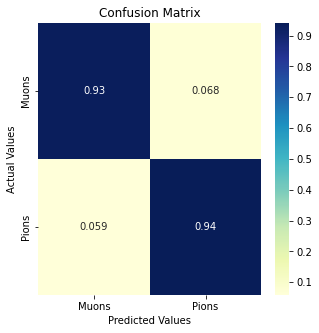

In [12]:
model_results(model=lgbm_c, X_test=X_test_bal, y_test=y_test_bal)

### XGBoost Classifier training and results

In [13]:
%%time
xgb_cl = XGBClassifier(
    random_state=random_state,
    tree_method="gpu_hist",
    gpu_id=gpu_id,
    predictor="gpu_predictor",
)
xgb_cl.fit(X_train, y_train)

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:54:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 8.21 s, sys: 358 ms, total: 8.57 s
Wall time: 1.12 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=64,
              num_parallel_tree=1, predictor='gpu_predictor', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [14]:
%%time
y_pred_xgb = xgb_cl.predict(X_test_bal)

CPU times: user 1.09 s, sys: 4.56 ms, total: 1.09 s
Wall time: 23.5 ms



Classification Report

              precision    recall  f1-score   support

       Muons       0.94      0.93      0.94     60279
       Pions       0.93      0.94      0.94     59973

    accuracy                           0.94    120252
   macro avg       0.94      0.94      0.94    120252
weighted avg       0.94      0.94      0.94    120252



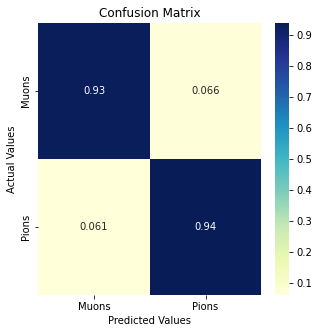

In [15]:
model_results(xgb_cl, X_test_bal, y_test_bal)

### AdaBoost Classifier training and results

In [16]:
%%time
ab_cl = AdaBoostClassifier(
    random_state=random_state,
    n_estimators=100
)
ab_cl.fit(X_train, y_train)

CPU times: user 1min 51s, sys: 3.65 s, total: 1min 55s
Wall time: 1min 55s


AdaBoostClassifier(n_estimators=100, random_state=123)

In [17]:
y_pred_adb = ab_cl.predict(X_test_bal)


Classification Report

              precision    recall  f1-score   support

       Muons       0.91      0.93      0.92     60279
       Pions       0.93      0.91      0.92     59973

    accuracy                           0.92    120252
   macro avg       0.92      0.92      0.92    120252
weighted avg       0.92      0.92      0.92    120252



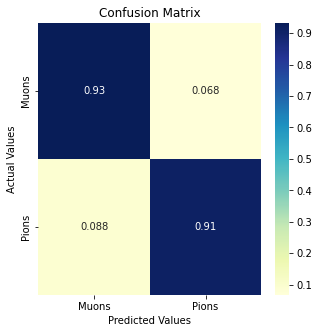

In [18]:
model_results(ab_cl, X_test_bal, y_test_bal)

In [19]:
# Comparing GBDT model performances on balanced test data across LGBM, XGBoost and AdaBoost
results_gbm = pd.DataFrame({
    "track_momentum": X_test_bal.track_momentum,
    "ring_radius": X_test_bal.ring_radius,
    "total_hits_filtered": X_test_bal.total_hits_filtered,
    "y_test": y_test_bal,
    "y_pred_lgb": y_pred_lgb,
    "y_pred_xgb": y_pred_xgb,
    "y_pred_adb": y_pred_adb,
    "compare_xgb_lgb": (y_pred_lgb == y_pred_xgb) 
    
})
results_gbm

,track_momentum,ring_radius,total_hits_filtered,y_test,y_pred_lgb,y_pred_xgb,y_pred_adb,compare_xgb_lgb
74161,24.321434,175.323746,22,0,0,0,0,True
107861,20.784155,169.408127,9,0,0,0,0,True
51081,22.166454,171.159927,11,0,0,0,0,True
25856,24.523874,170.851730,10,0,0,0,1,True
66792,18.591120,165.436035,15,0,0,0,0,True
...,...,...,...,...,...,...,...,...
103572,38.928314,178.491653,19,1,1,1,1,True
103577,35.705940,178.665436,12,1,1,1,1,True
103581,44.021793,184.784882,14,1,0,0,0,True
103588,36.271393,178.187836,15,1,1,1,1,True


## Analysis of different GBDT model predictions

In [20]:
# Mismatch between lgbm and xgb predictions
print(f"Total mismatch between LBGM and XGB: {results_gbm[results_gbm.compare_xgb_lgb==False].shape[0]}")
results_gbm[results_gbm.compare_xgb_lgb==False]

Total mismatch between LBGM and XGB: 718


,track_momentum,ring_radius,total_hits_filtered,y_test,y_pred_lgb,y_pred_xgb,y_pred_adb,compare_xgb_lgb
11468,15.241979,133.349411,7,0,1,0,1,False
116170,20.094755,167.074280,38,1,0,1,1,False
119246,19.823019,84.123199,5,1,1,0,0,False
121948,24.847961,170.266617,9,1,0,1,1,False
127154,23.325472,167.271591,11,1,1,0,1,False
...,...,...,...,...,...,...,...,...
102141,43.599106,184.328522,17,1,1,0,0,False
102359,39.024002,182.702621,10,1,0,1,0,False
102530,37.762753,181.884323,9,1,0,1,0,False
102593,39.863125,182.899414,11,1,0,1,0,False


In [21]:
# Comparing xgboost predictions with actual labels
mis_preds = results_gbm.query('y_test != y_pred_xgb')
print(f"Total mis-predictions: {mis_preds.shape[0]}")
mis_preds

Total mis-predictions: 7642


,track_momentum,ring_radius,total_hits_filtered,y_test,y_pred_lgb,y_pred_xgb,y_pred_adb,compare_xgb_lgb
37431,22.952774,165.764618,4,0,1,1,0,True
45453,22.831854,163.029800,10,0,1,1,1,True
74731,18.101425,148.652878,5,0,1,1,0,True
91616,22.583714,123.278931,10,0,1,1,1,True
18582,23.139898,155.129761,5,0,1,1,1,True
...,...,...,...,...,...,...,...,...
103500,38.797981,183.389221,14,1,0,0,0,True
103517,35.021149,182.015976,12,1,0,0,0,True
103527,40.636719,184.285721,11,1,0,0,0,True
103566,38.314316,184.706406,19,1,0,0,0,True


### Best performing model overall, and selecting one model going forward

Although, models performed similarly on the test data, XGBoost performance is better than the rest in terms of speed due to GPU accelaration support. Therefore, going forward, the GBDT model will be XGBClassifier with Sklearn API (native implementation is dmlc XGBoost)

In [22]:

# XGBoost evaluation results on balanced test set for plotting function

y_probs_xgb = xgb_cl.predict_proba(X_test_bal)[:,1]
df_gbm = pd.DataFrame({
    "labels": y_test_bal,
    "predictions": y_pred_xgb,
    "probabilities": y_probs_xgb,
    "momentum": X_test_bal.track_momentum
    }
)
df_gbm

,labels,predictions,probabilities,momentum
74161,0,0,0.001645,24.321434
107861,0,0,0.002966,20.784155
51081,0,0,0.001681,22.166454
25856,0,0,0.220906,24.523874
66792,0,0,0.000125,18.591120
...,...,...,...,...
103572,1,1,0.995130,38.928314
103577,1,1,0.947483,35.705940
103581,1,0,0.392458,44.021793
103588,1,1,0.975933,36.271393


### Saving results df

In [23]:
# Saving XGBoost results on balanced test set
path_preds_bal = '/fast_scratch_1/capstone_2022/models/xgboost/saved_models/xgb_balanced.csv'
df_gbm.to_csv(path_preds_bal)

### Plotting ROC curve

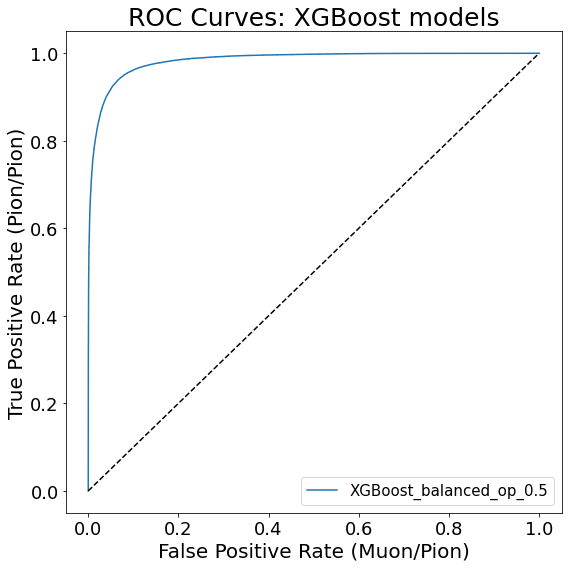

In [24]:
# ROC curve at default (0.5) operating point
results = {
    "XGBoost_balanced_op_0.5": path_preds_bal
}
plot_roc_curves(
    results,
    title="ROC Curves: XGBoost models"
)

### Plotting Efficiency curves at different operating points

Operating point: 0.5
--------------------


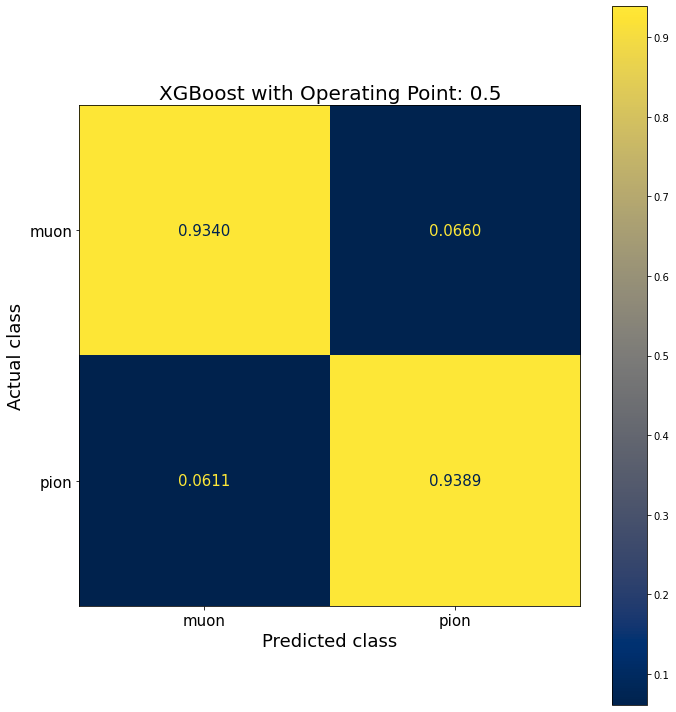

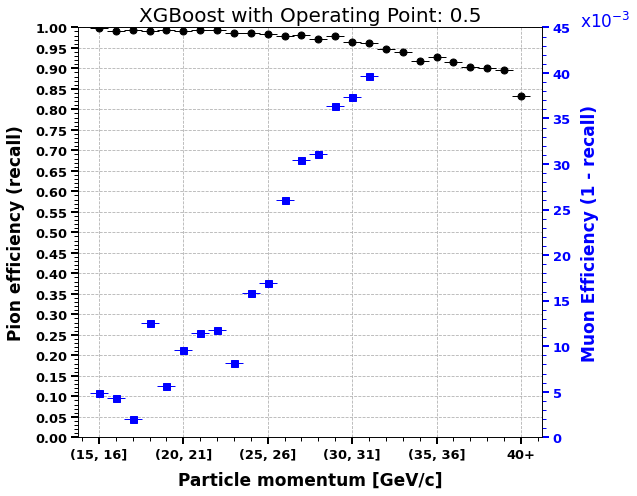

Operating point: 0.6
--------------------


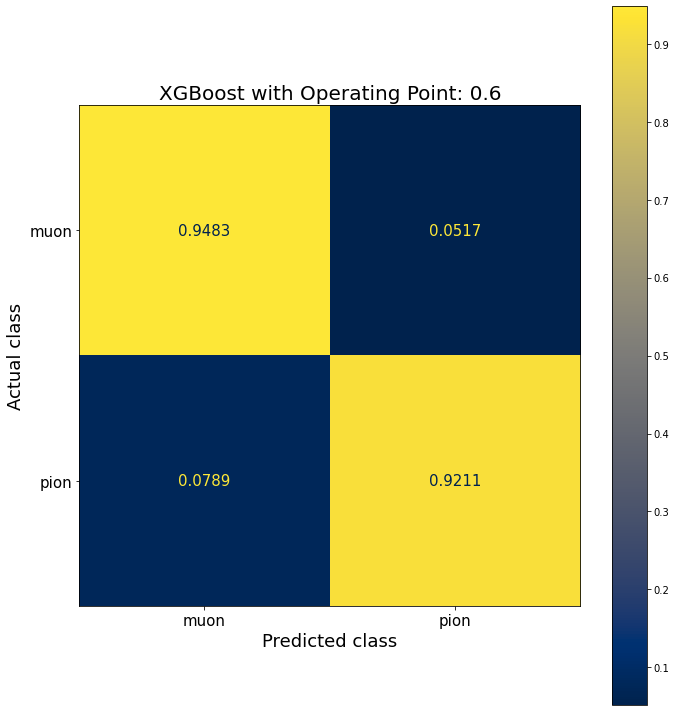

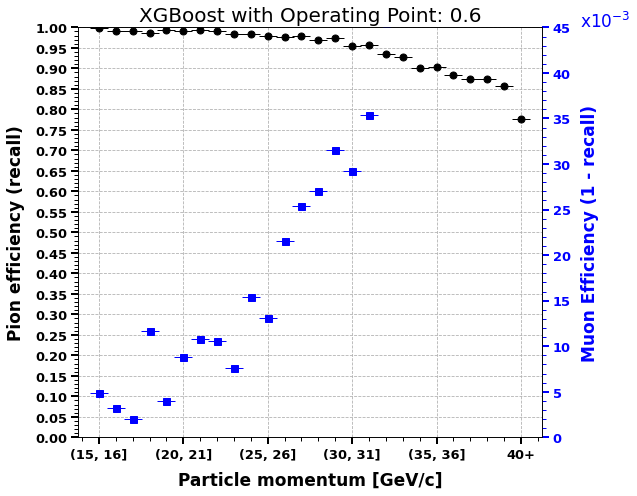

Operating point: 0.7
--------------------


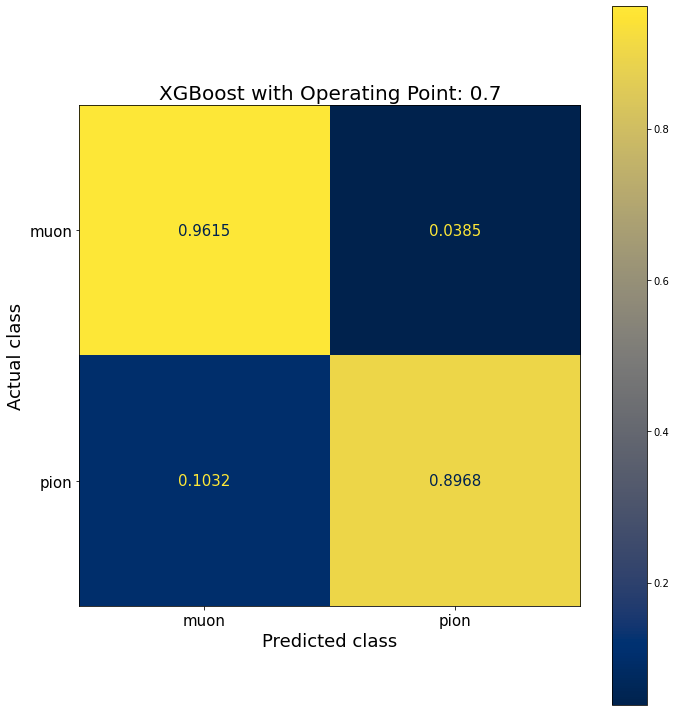

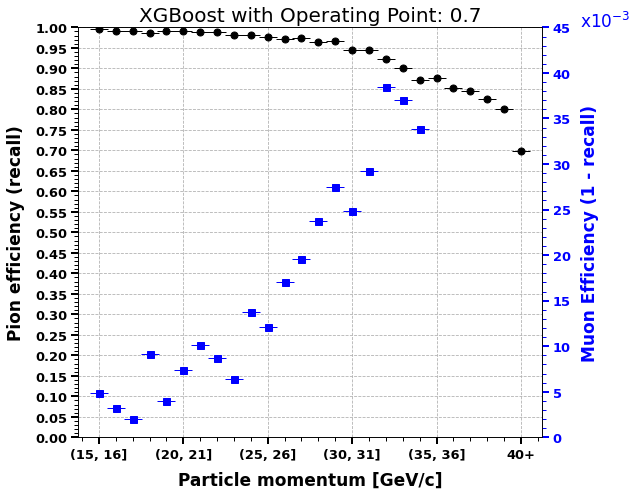

Operating point: 0.8
--------------------


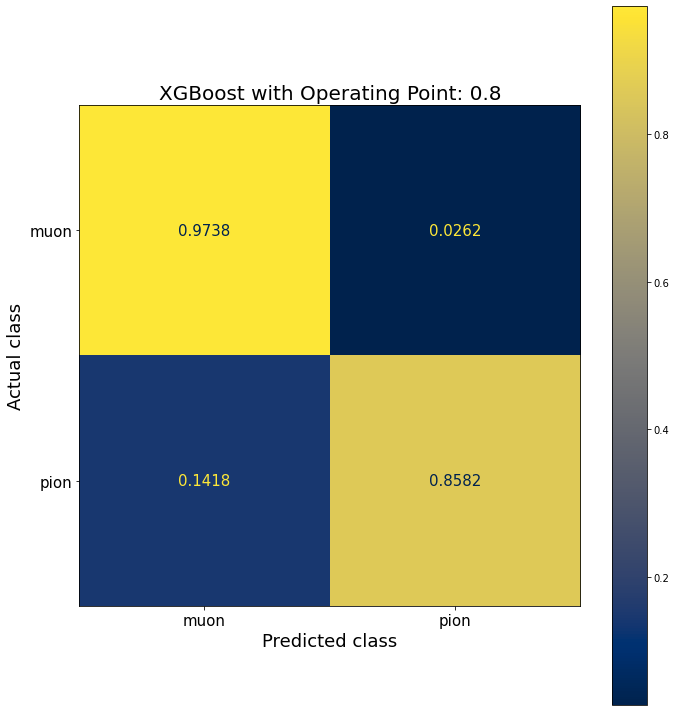

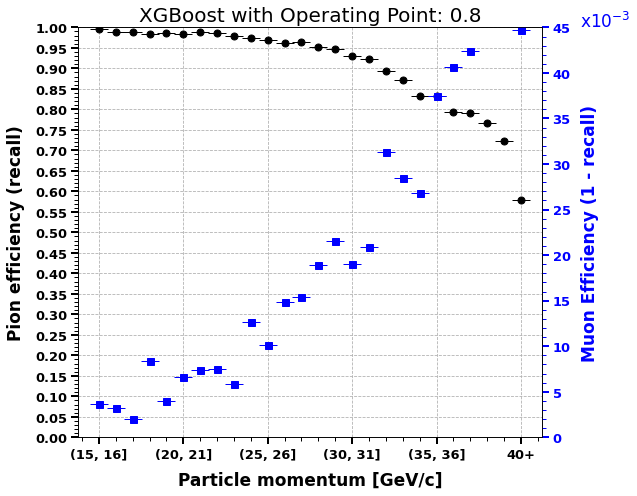

Operating point: 0.85
---------------------


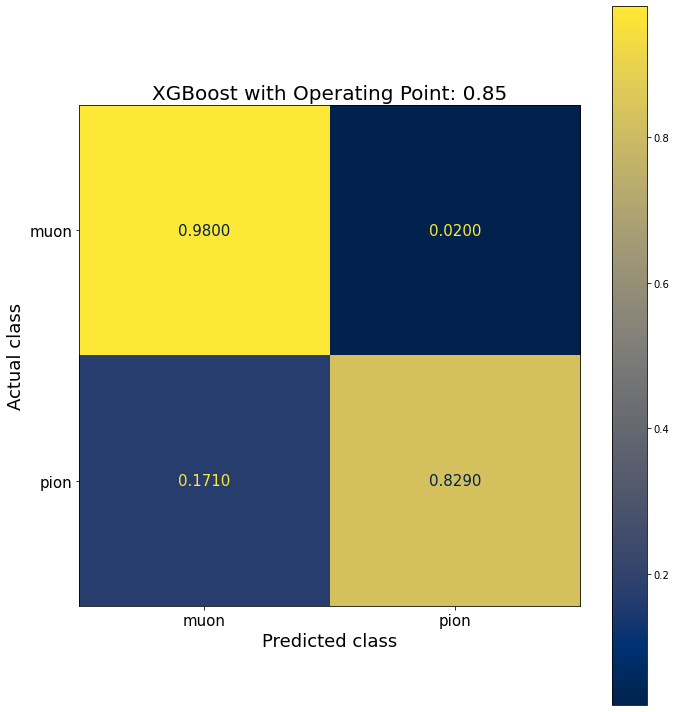

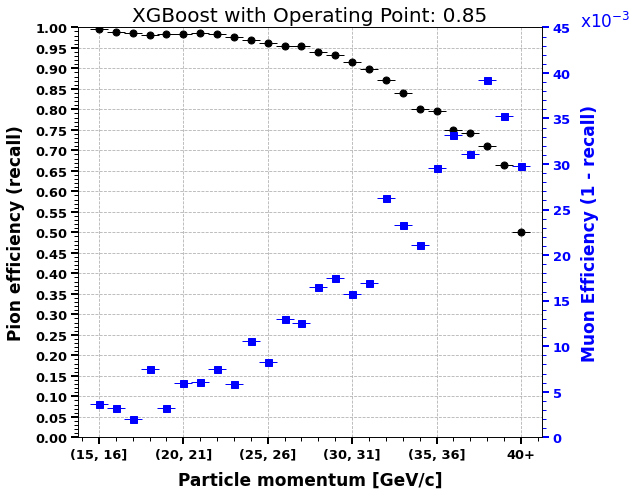

Operating point: 0.9
--------------------


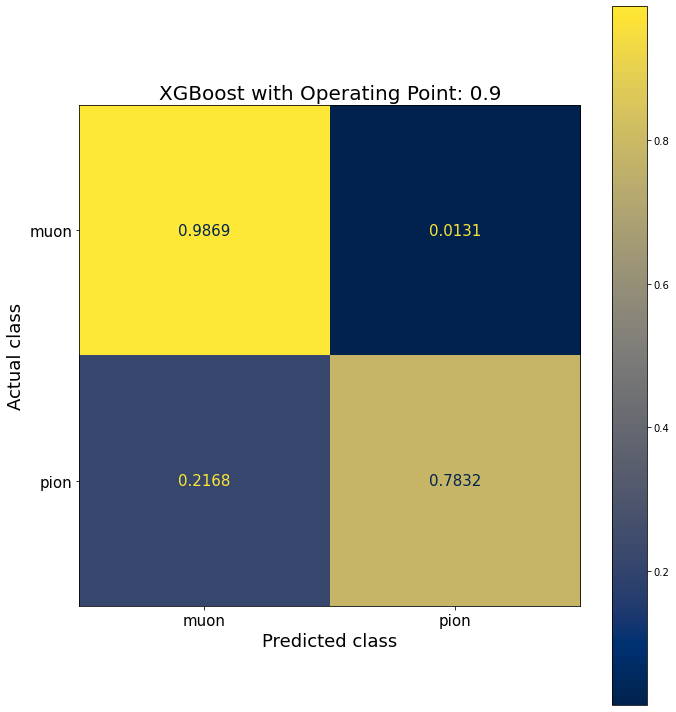

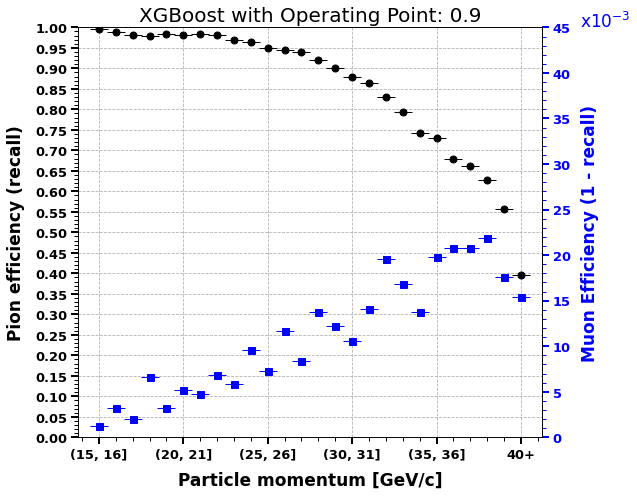

Operating point: 0.91
---------------------


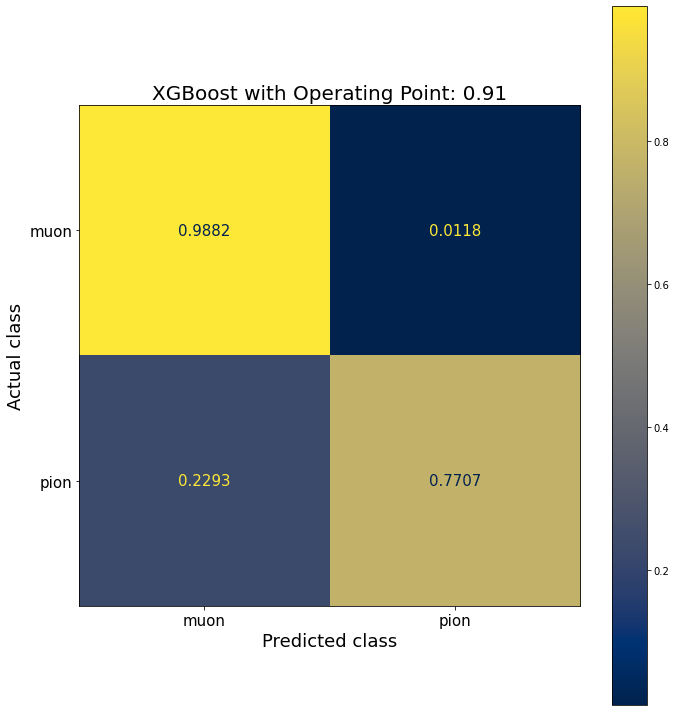

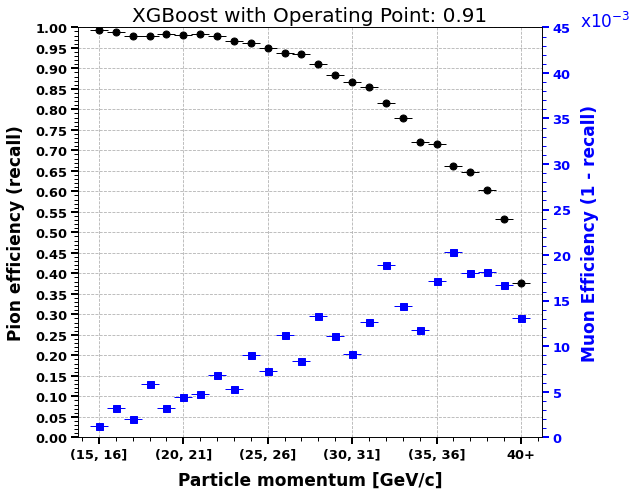

Operating point: 0.92
---------------------


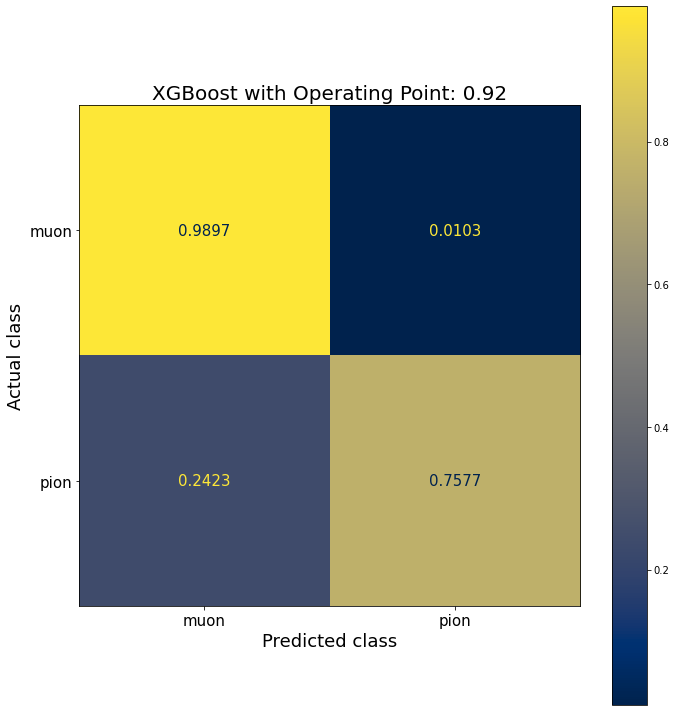

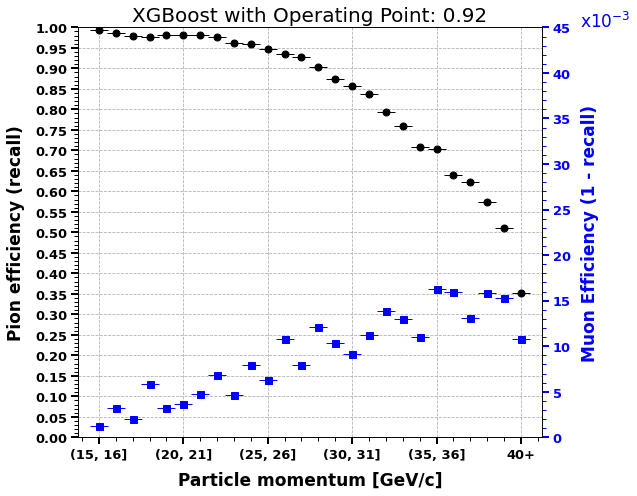

Operating point: 0.93
---------------------


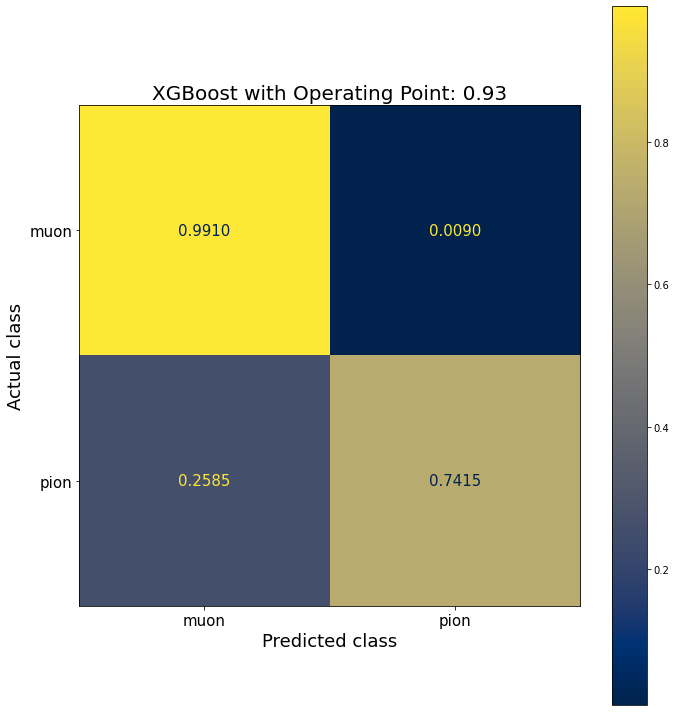

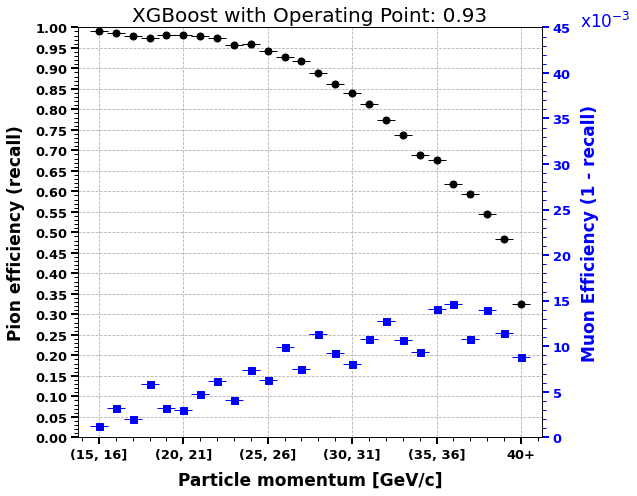

Operating point: 0.94
---------------------


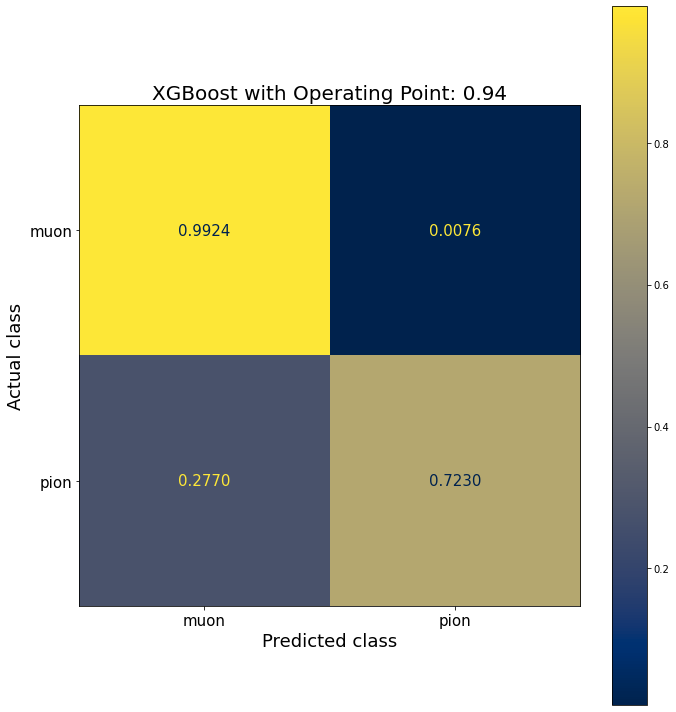

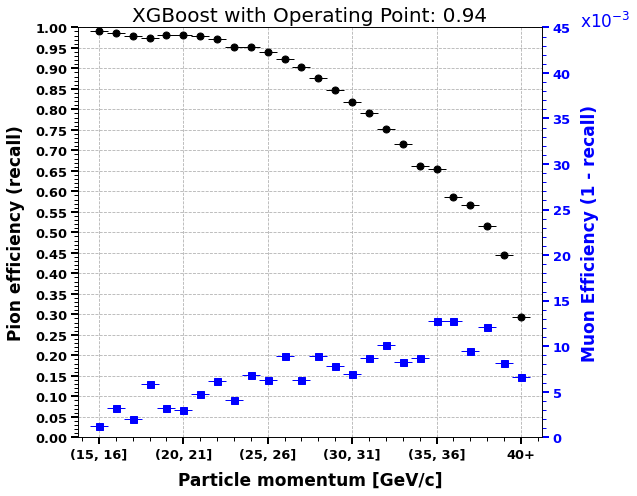

Operating point: 0.95
---------------------


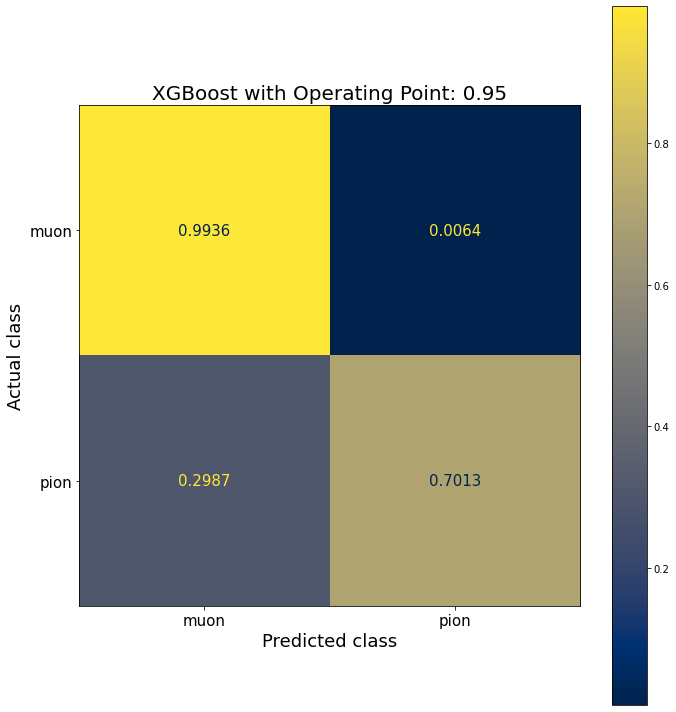

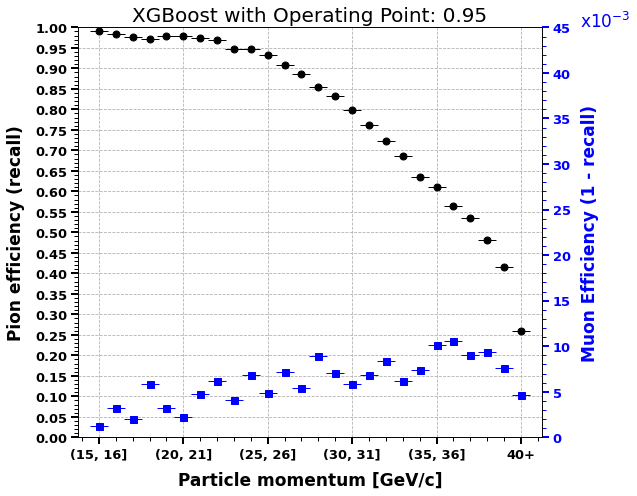

Operating point: 0.96
---------------------


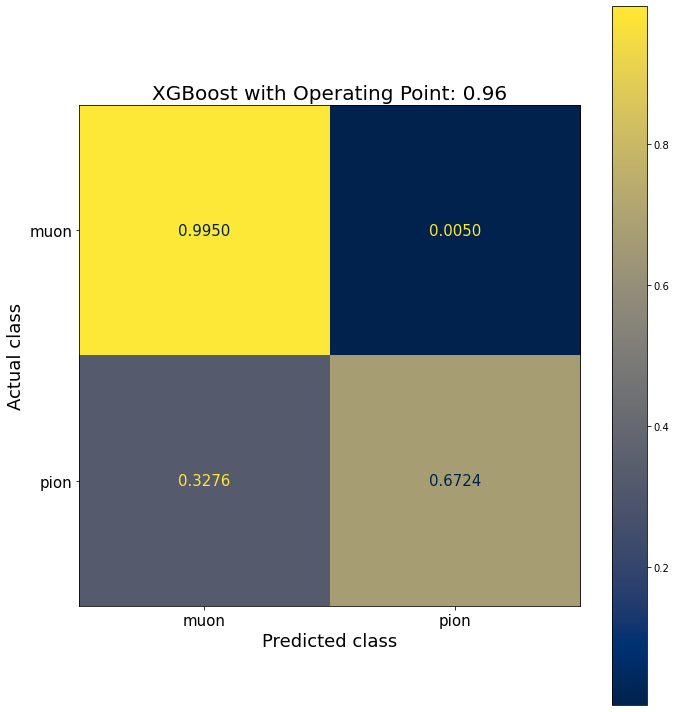

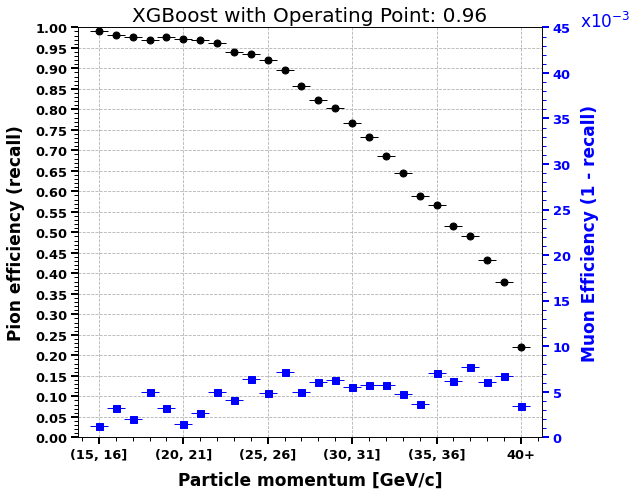

Operating point: 0.97
---------------------


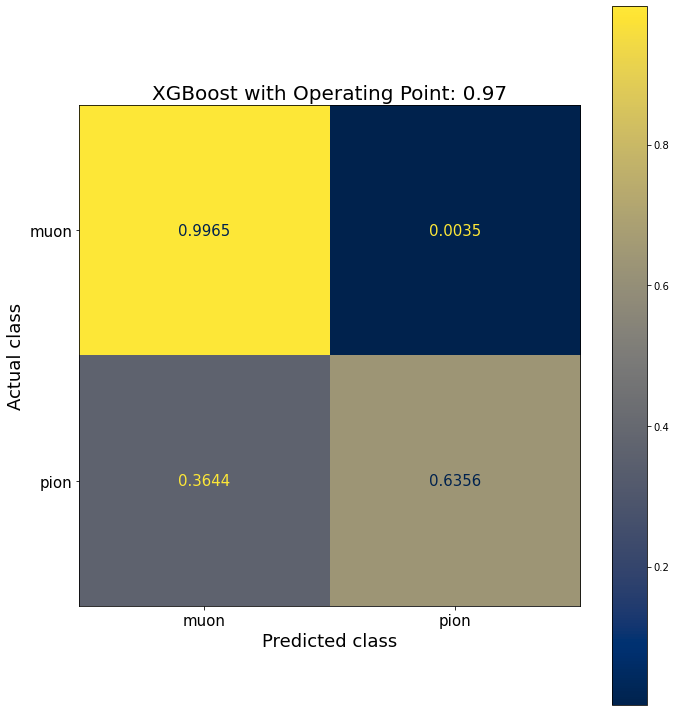

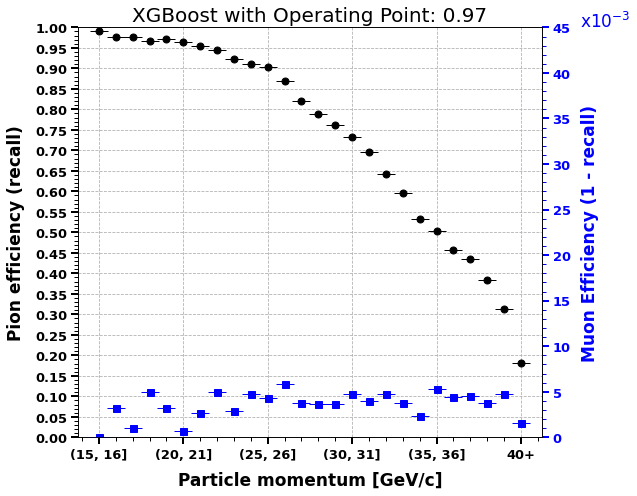

Operating point: 0.98
---------------------


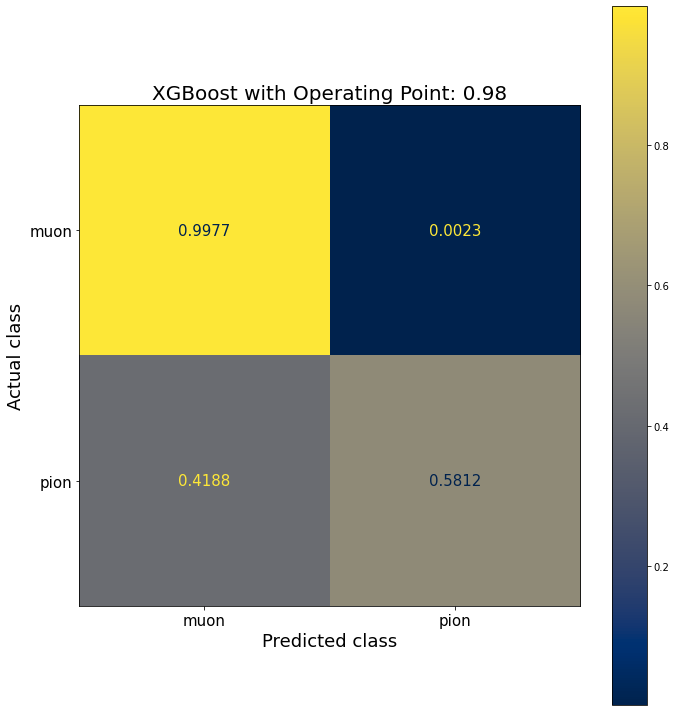

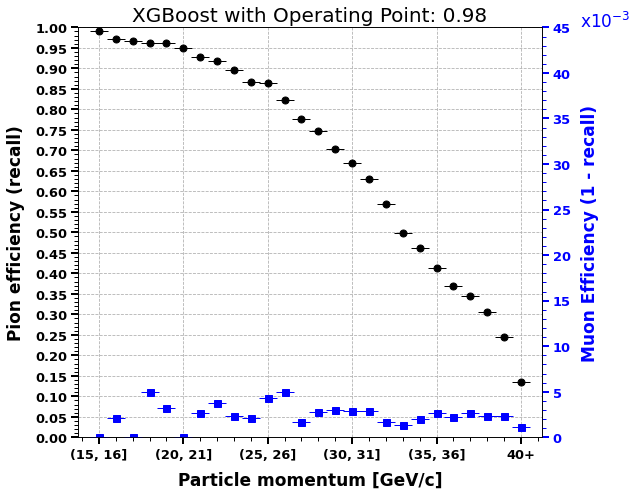

Operating point: 0.99
---------------------


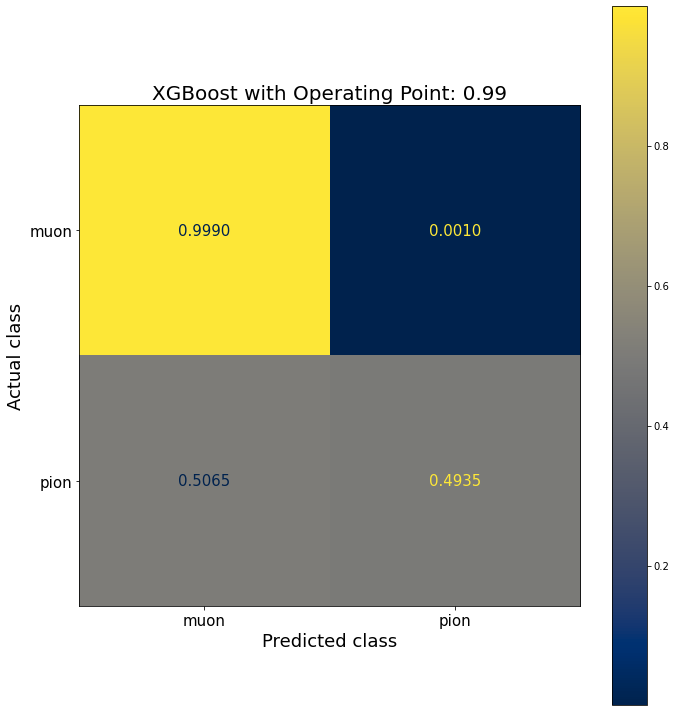

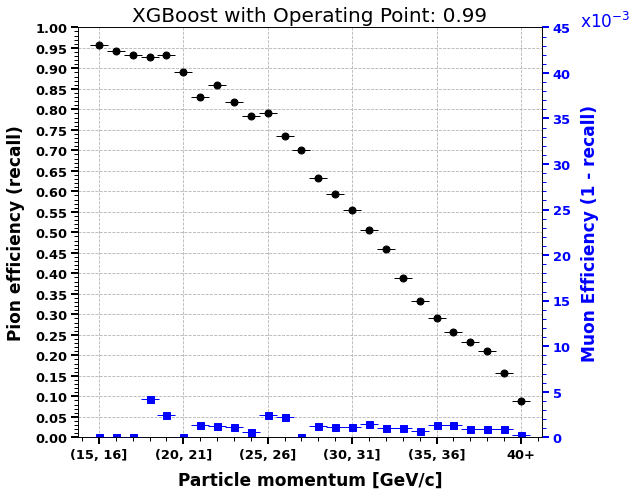

In [25]:
file_path = '/fast_scratch_1/capstone_2022/models/xgboost/saved_models/xgb_balanced.csv'

operating_point = [
    0.50,
    0.60,
    0.70,
    0.80,
    0.85,
    0.90,
    0.91,
    0.92,
    0.93,
    0.94,
    0.95,
    0.96,
    0.97,
    0.98,
    0.99,
]

for op in operating_point:
    print("\033[1;33m" + "Operating point: " + str(op) + "\033[0m")
    print("\033[1;33m" + "-" * len("Operating point: " + str(op)) + "\033[0m")
    
    title=f"XGBoost with Operating Point: {op}"
    
    df = pd.read_csv(file_path)
    df["predictions"] = np.where(df["probabilities"] > op, 1, 0)
    
    plot_cm(
        y_true=df["labels"],
        y_pred=df["predictions"],
        title=title
    )
    
    plot_efficiencies(
        path=file_path,
        title=title,
        cern_scale=True,
        pion_axlims=(0, 1),
        muon_axlims=(0, 45),
        pion_axticks=(0.05, 0.01),
        muon_axticks=(5, 1),
        op_point=op
)

### Choosing best operating point
In order to balance the trade off between pion efficiencies (>0.75) and muon efficiencies(~ 0.01), 0.92 seems to be the best operating point for balanced test set.

### Efficiency plot of the best performing XGB model with operating point= 0.92

Operating point: 0.92
---------------------


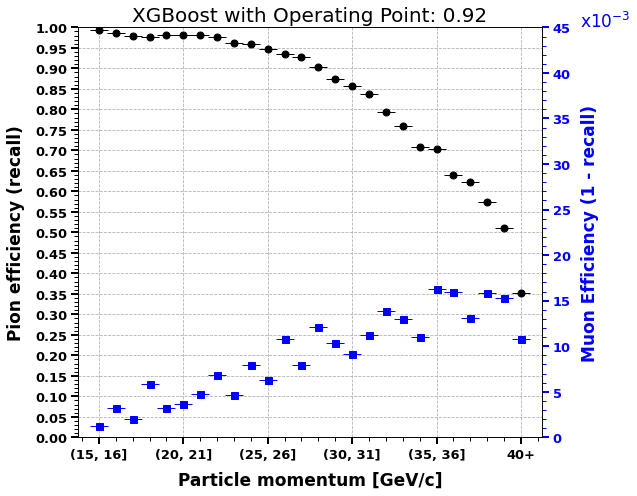

In [26]:
file_path = '/fast_scratch_1/capstone_2022/models/xgboost/saved_models/xgb_balanced.csv'

operating_point = [0.92]

for op in operating_point:
    print("\033[1;33m" + "Operating point: " + str(op) + "\033[0m")
    print("\033[1;33m" + "-" * len("Operating point: " + str(op)) + "\033[0m")
    
    title=f"XGBoost with Operating Point: {op}"
    
    df = pd.read_csv(file_path)
    df["predictions"] = np.where(df["probabilities"] > op, 1, 0)
    
    plot = plot_efficiencies(
        path=file_path,
        title=title,
        cern_scale=True,
        pion_axlims=(0, 1),
        muon_axlims=(0, 45),
        pion_axticks=(0.05, 0.01),
        muon_axticks=(5, 1),
        save="docs/final_report/images/xgb_results_bal_0.92.svg",
        op_point=op
    )

## *Momentum Bias analysis*: Comparing models trained globally (15-45 GeV/c) and locally (15-25, 25-35 & 35-45 GeV/c)

- Model: XGBClassifier
- Train data: 0.75 split of balanced data (B and C)
- Test data: 0.25 split of balanced data (B and C)

In [27]:
%%time
# Creating XGBoost model instance
xgb_cl_ = XGBClassifier(
    random_state=random_state,
    tree_method="gpu_hist",
    gpu_id=gpu_id,
    predictor="gpu_predictor",
)

# Creating train test sets at 0.25 % split
xgb_cl_15_25, X_train_1525, X_test_1525, y_train_1525, y_test_1525 = gbt_binwise(
    model=xgb_cl_,
    df_bal=df_train, 
    bin_low=15, 
    bin_high=25
)

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:56:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 11.2 s, sys: 344 ms, total: 11.5 s
Wall time: 401 ms



Classification Report

              precision    recall  f1-score   support

       Muons       0.99      0.99      0.99     54173
       Pions       0.99      0.99      0.99     53514

    accuracy                           0.99    107687
   macro avg       0.99      0.99      0.99    107687
weighted avg       0.99      0.99      0.99    107687



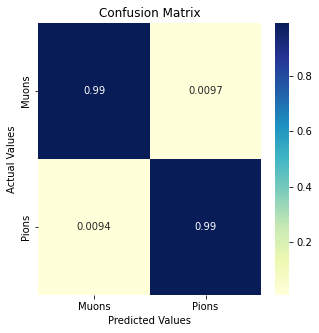

In [28]:
model_results(model = xgb_cl_15_25, X_test = X_test_1525, y_test = y_test_1525)

In [29]:
%%time

# Creating XGBoost model instance
xgb_cl_ = XGBClassifier(
    random_state=random_state,
    tree_method="gpu_hist",
    gpu_id=gpu_id,
    predictor="gpu_predictor",
)

xgb_cl_25_35, X_train_2535, X_test_2535, y_train_2535, y_test_2535 = gbt_binwise(
    model=xgb_cl_,
    df_bal=df_train, 
    bin_low=25, 
    bin_high=35
)

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:56:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 12.6 s, sys: 402 ms, total: 13 s
Wall time: 513 ms



Classification Report

              precision    recall  f1-score   support

       Muons       0.96      0.96      0.96    104618
       Pions       0.96      0.96      0.96    104505

    accuracy                           0.96    209123
   macro avg       0.96      0.96      0.96    209123
weighted avg       0.96      0.96      0.96    209123



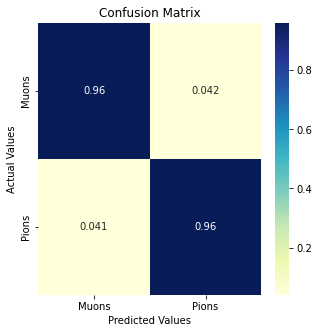

In [30]:
model_results(model = xgb_cl_25_35, X_test = X_test_2535, y_test = y_test_2535)

In [31]:
%%time

# Creating XGBoost model instance
xgb_cl_ = XGBClassifier(
    random_state=random_state,
    tree_method="gpu_hist",
    gpu_id=gpu_id,
    predictor="gpu_predictor",
)

xgb_cl_35_45, X_train_3545, X_test_3545, y_train_3545, y_test_3545 = gbt_binwise(
    model=xgb_cl_,
    df_bal=df_train, 
    bin_low=35, 
    bin_high=45
)

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:56:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 12.1 s, sys: 439 ms, total: 12.6 s
Wall time: 453 ms



Classification Report

              precision    recall  f1-score   support

       Muons       0.87      0.87      0.87     81803
       Pions       0.87      0.87      0.87     81552

    accuracy                           0.87    163355
   macro avg       0.87      0.87      0.87    163355
weighted avg       0.87      0.87      0.87    163355



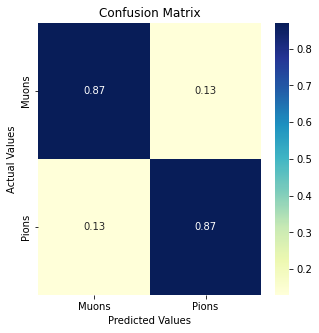

In [32]:
model_results(model = xgb_cl_35_45, X_test = X_test_3545, y_test = y_test_3545)

### ROC Curves

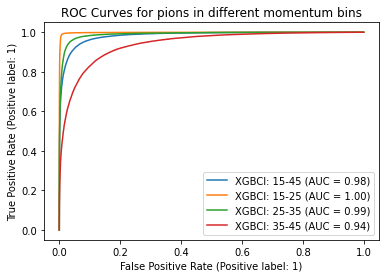

<Figure size 432x288 with 0 Axes>

In [33]:
# ROC Curves
fig = None
fig = plot_roc_curve(xgb_cl, X_test_bal, y_test_bal, name="XGBCl: 15-45")
fig = plot_roc_curve(xgb_cl_15_25, X_test_1525, y_test_1525, ax=fig.ax_, name="XGBCl: 15-25")
fig = plot_roc_curve(xgb_cl_25_35, X_test_2535, y_test_2535, ax = fig.ax_, name="XGBCl: 25-35")
fig = plot_roc_curve(xgb_cl_35_45, X_test_3545, y_test_3545, ax = fig.ax_, name="XGBCl: 35-45")
plt.title("ROC Curves for pions in different momentum bins")
plt.show()
plt.savefig("docs/final_report/images/xgb_results_pbins.svg")

## Evaluating results on 35-45 momentum bins with two different models: globally and locally trained xgboost models

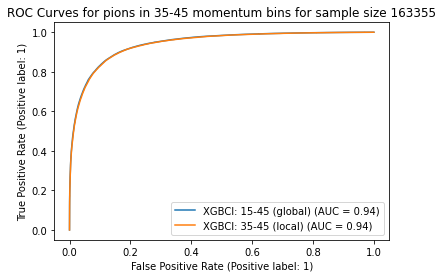

<Figure size 432x288 with 0 Axes>

In [34]:
# ROC Curves
fig = None
# Globally trained model performance on 35-45 momentum bin
fig = plot_roc_curve(xgb_cl, X_test_3545, y_test_3545, name="XGBCl: 15-45 (global)")

# Locally trained model performance on 35-45 momentum bin
fig = plot_roc_curve(xgb_cl_35_45, X_test_3545, y_test_3545, ax = fig.ax_, name="XGBCl: 35-45 (local)")

plt.title(f"ROC Curves for pions in 35-45 momentum bins for sample size {X_test_3545.shape[0]}")
plt.show()
plt.savefig("docs/final_report/images/xgb_results_pbias_35_45.svg")

## Evaluating model on unbalanced test data

In [35]:
# X, y
X_test_unbal = df_test_unbal.loc[:, [
    'track_momentum',
    'ring_radius',
    'total_hits_filtered'
]]
y_test_unbal = df_test_unbal.loc[:,'label']

In [36]:
# Summary of test data
pd.DataFrame(
    {
        "df_train": df_train.label.value_counts(),
        "df_test_bal": df_test_bal.label.value_counts(),
        "df_test_unbal": df_test_unbal.label.value_counts()
    },    
)

,df_train,df_test_bal,df_test_unbal
0,962982,60279,627355
1,957671,59973,67725


In [37]:
# preds
y_pred_xgb_unbal = xgb_cl.predict(X_test_unbal)

In [38]:
# XGBoost evaluation results on balanced test set for plotting function
y_probs_xgb_unbal = xgb_cl.predict_proba(X_test_unbal)[:,1]
df_gbm_unbal = pd.DataFrame({
    "labels": y_test_unbal,
    "predictions": y_pred_xgb_unbal,
    "probabilities": y_probs_xgb_unbal,
    "momentum": X_test_unbal.track_momentum
    }
)
df_gbm_unbal

,labels,predictions,probabilities,momentum
0,0,0,0.088996,39.102062
1,0,0,0.305765,43.845306
2,0,0,0.089208,49.434795
3,0,0,0.028063,36.152966
4,0,0,0.175092,65.520844
...,...,...,...,...
103591,1,1,0.995828,29.149534
103592,1,1,0.988218,30.451511
103593,1,1,0.935501,42.269211
103594,1,0,0.222953,55.185467


### Saving results df

In [39]:
# Saving XGBoost results on balanced test set
path_preds_unbal = '/fast_scratch_1/capstone_2022/models/xgboost/saved_models/xgb_unbalanced.csv'
df_gbm_unbal.to_csv(path_preds_unbal)

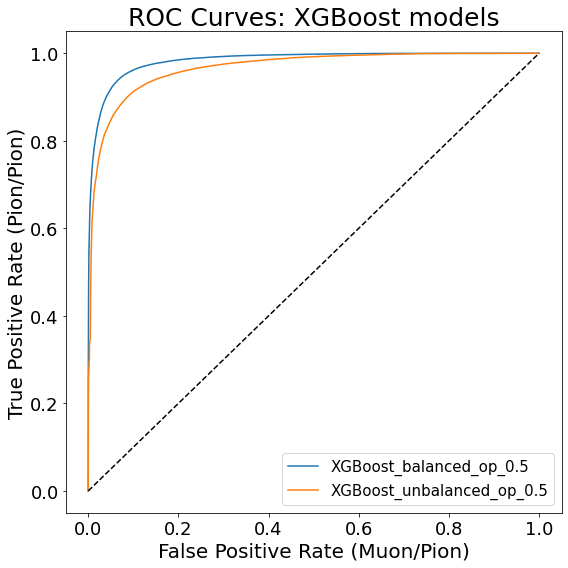

In [40]:
# ROC curve at default (0.5) operating point
results["XGBoost_unbalanced_op_0.5"] = path_preds_unbal
plot_roc_curves(
    results,
    title="ROC Curves: XGBoost models"
)

### Plotting Efficiency curves at different operating points

Operating point: 0.5
--------------------


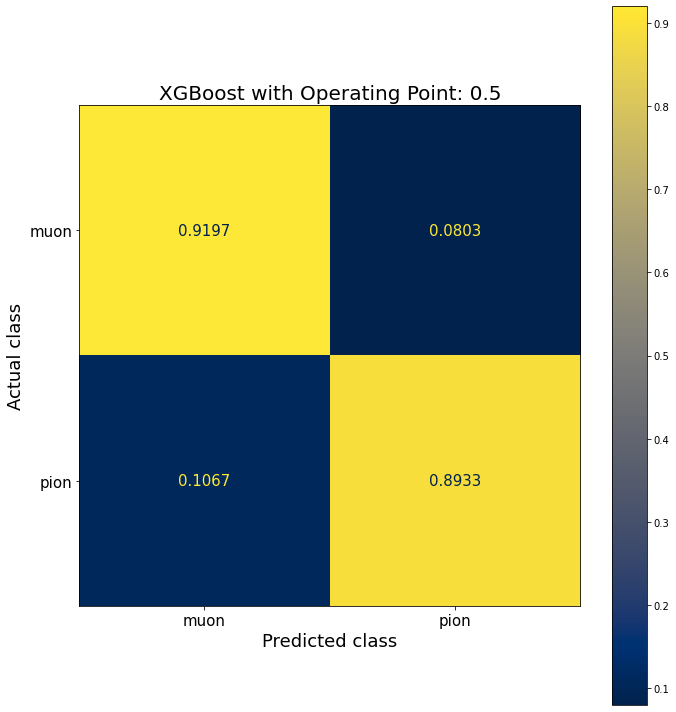

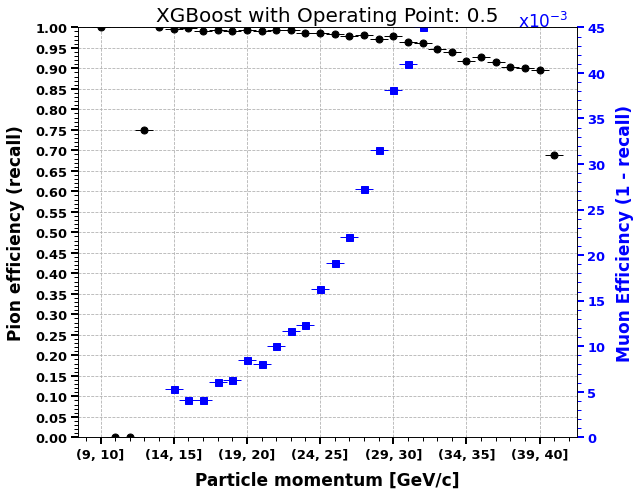

Operating point: 0.6
--------------------


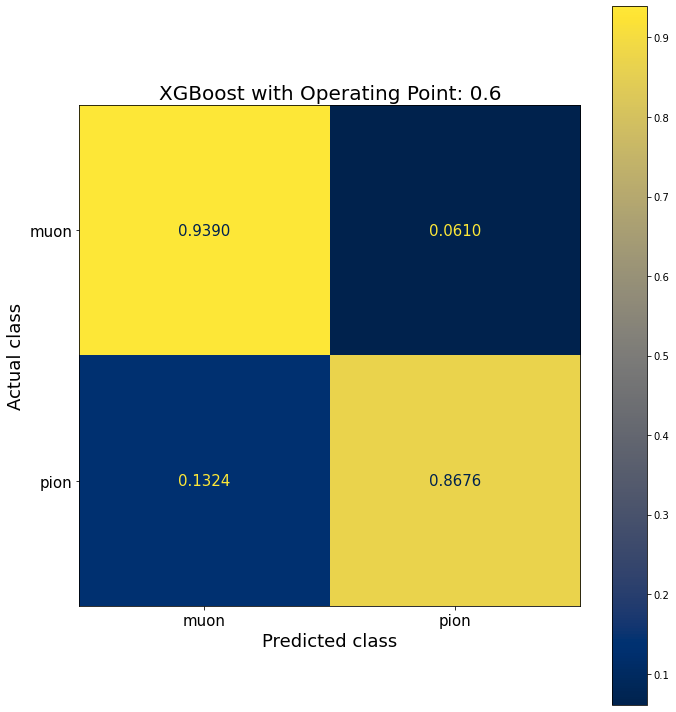

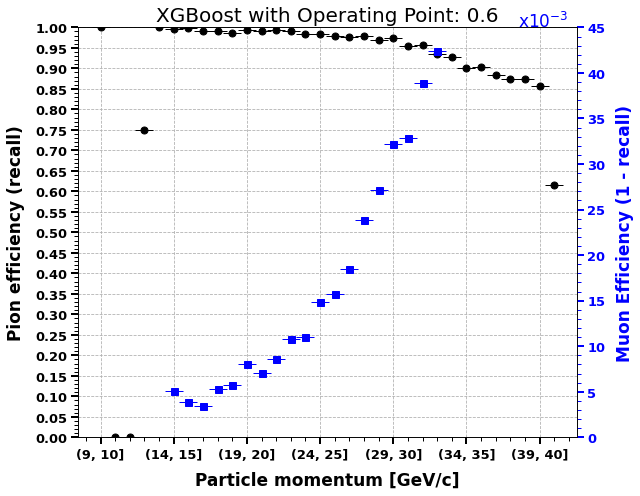

Operating point: 0.7
--------------------


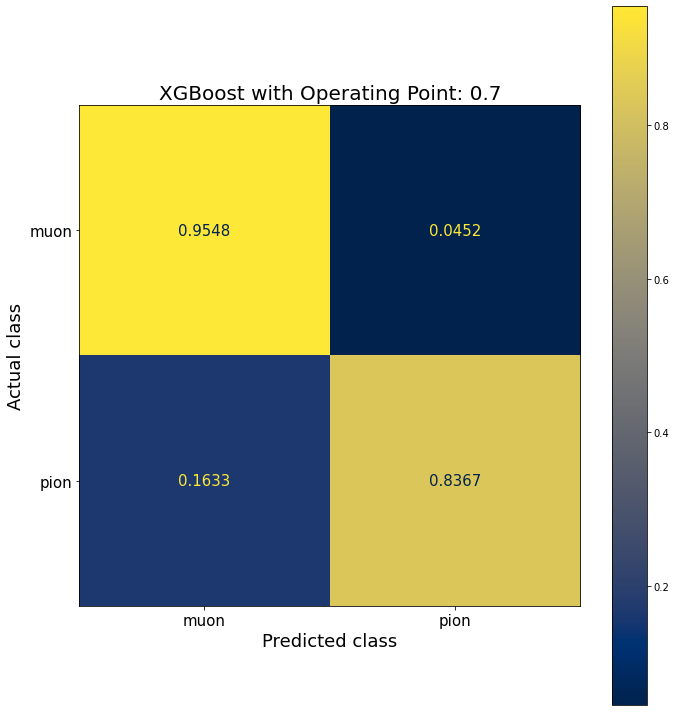

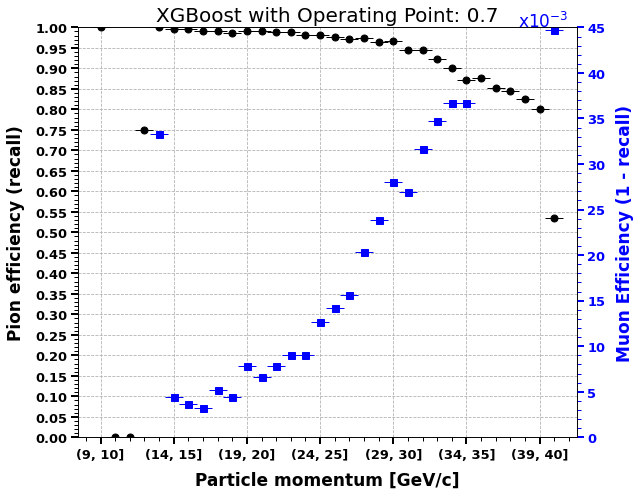

Operating point: 0.8
--------------------


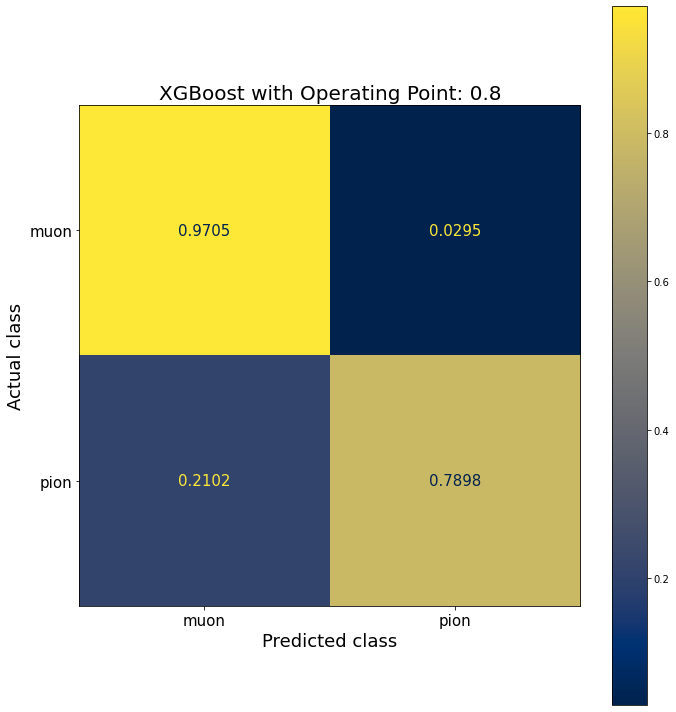

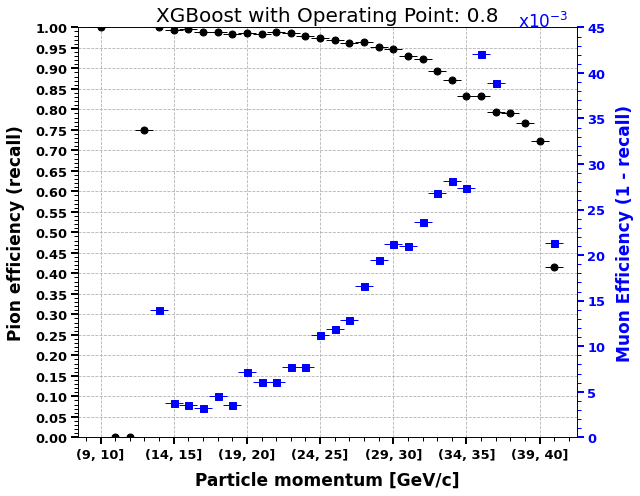

Operating point: 0.85
---------------------


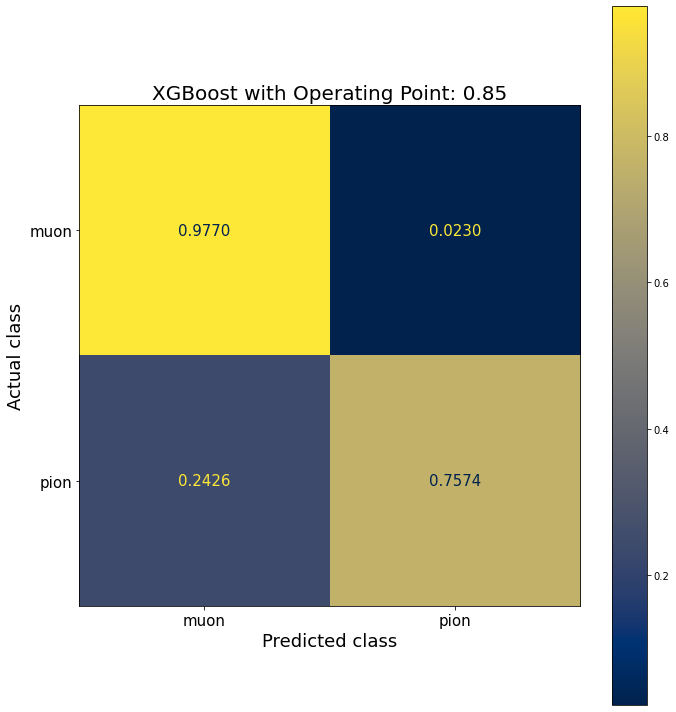

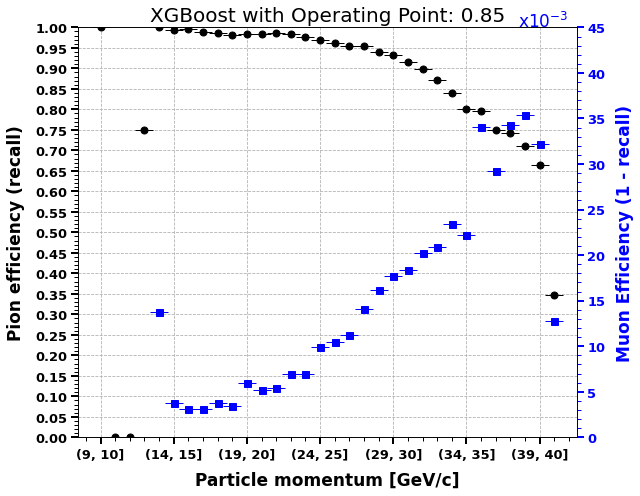

Operating point: 0.9
--------------------


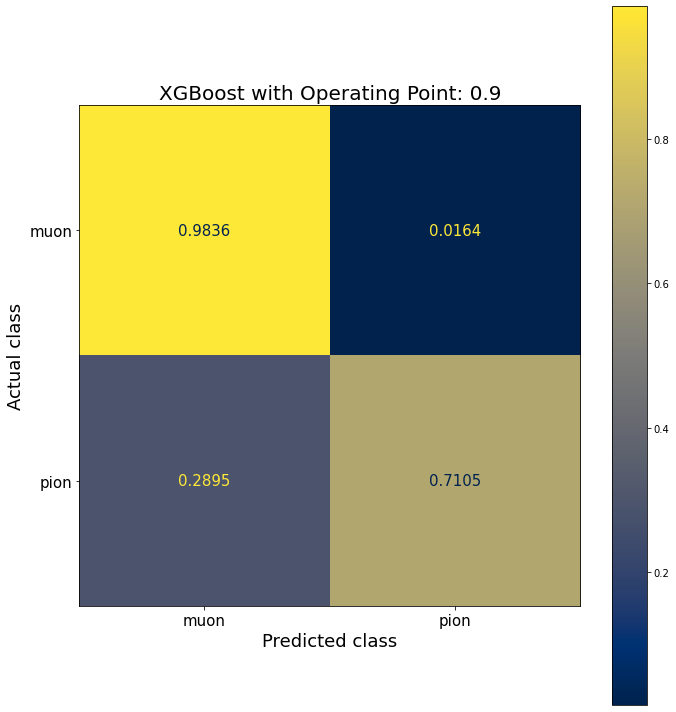

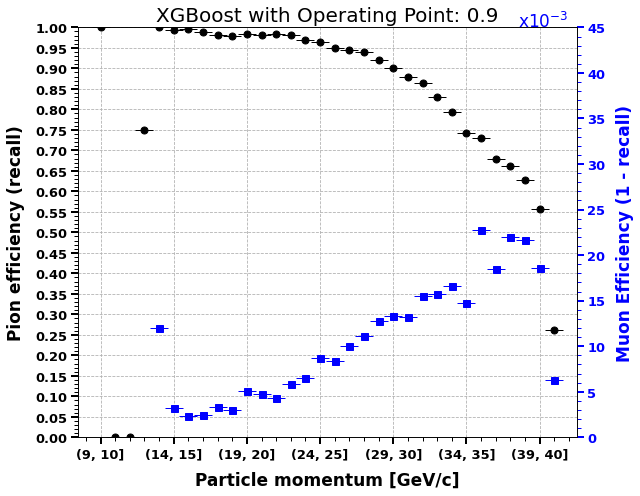

Operating point: 0.91
---------------------


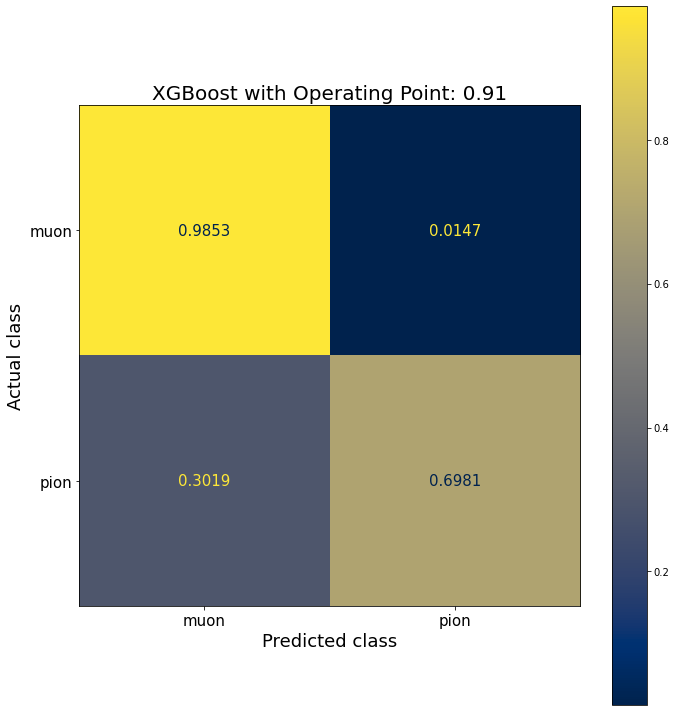

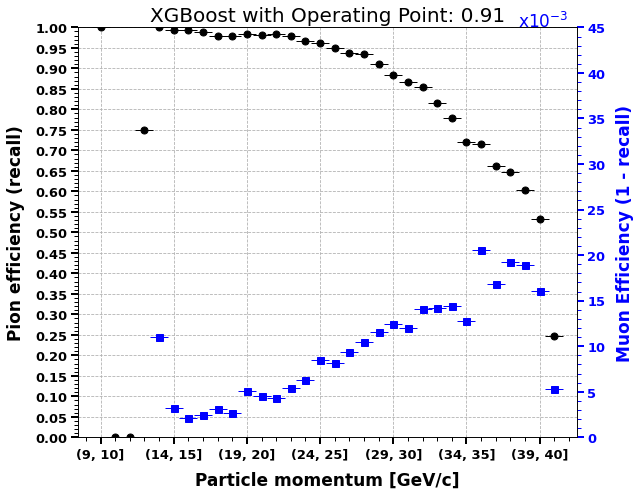

Operating point: 0.92
---------------------


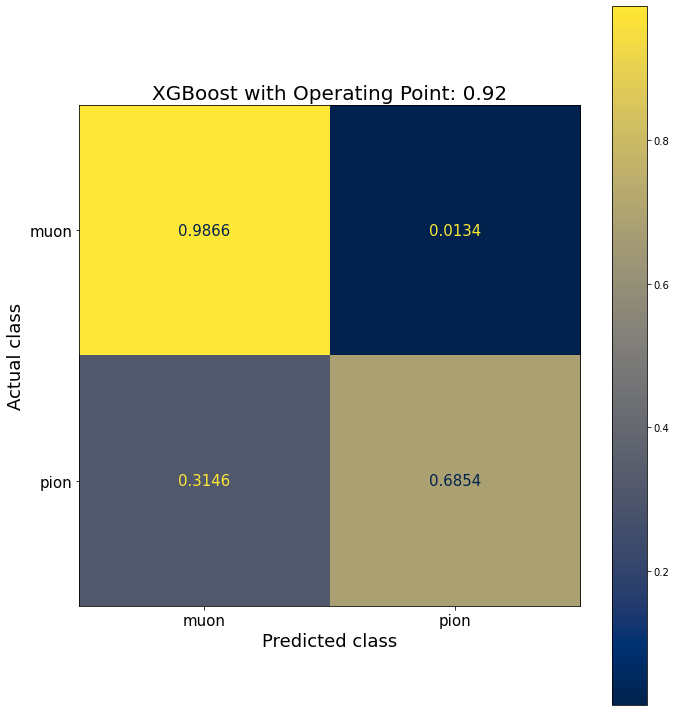

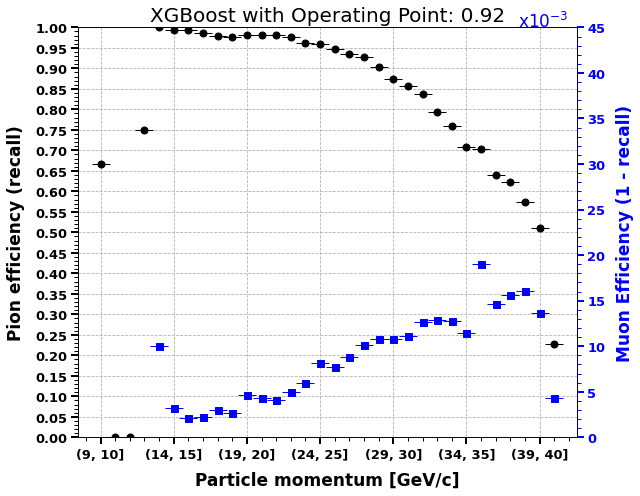

Operating point: 0.93
---------------------


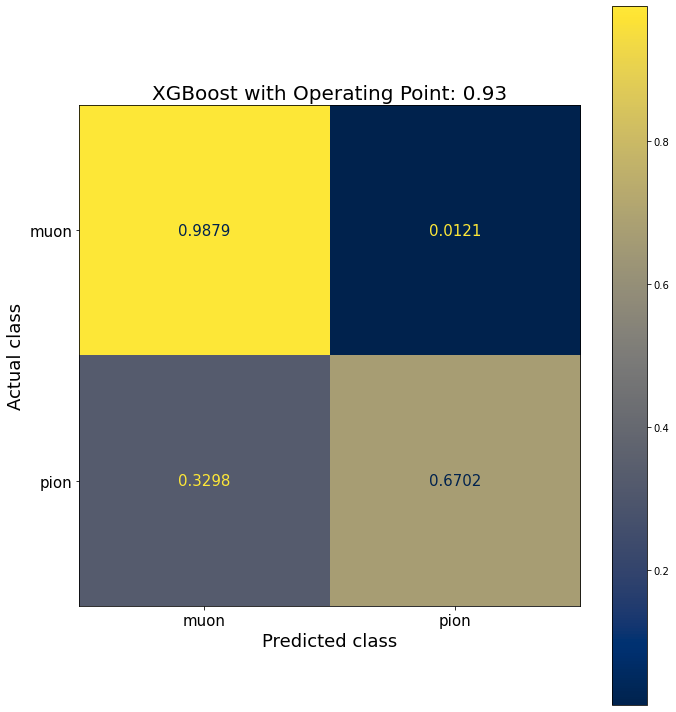

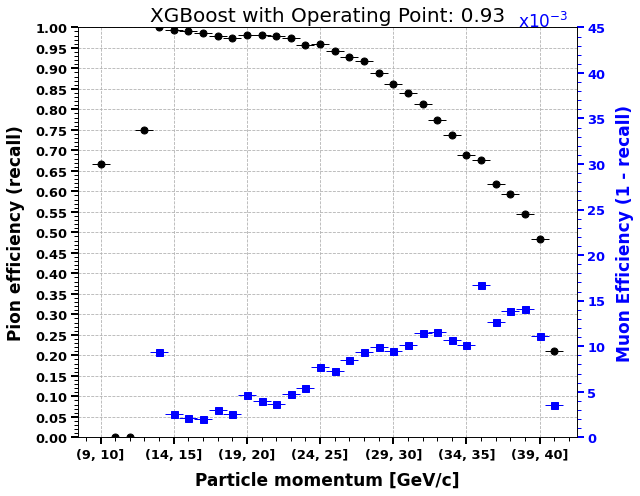

Operating point: 0.94
---------------------


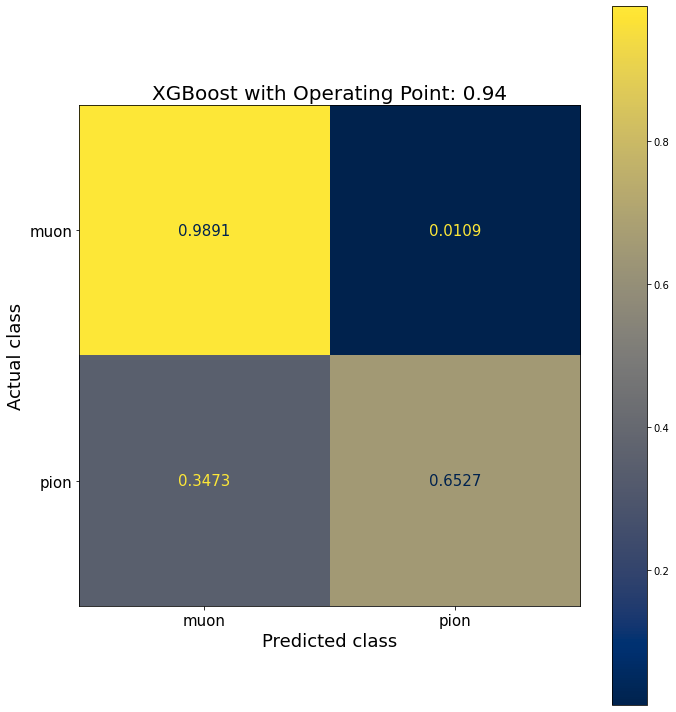

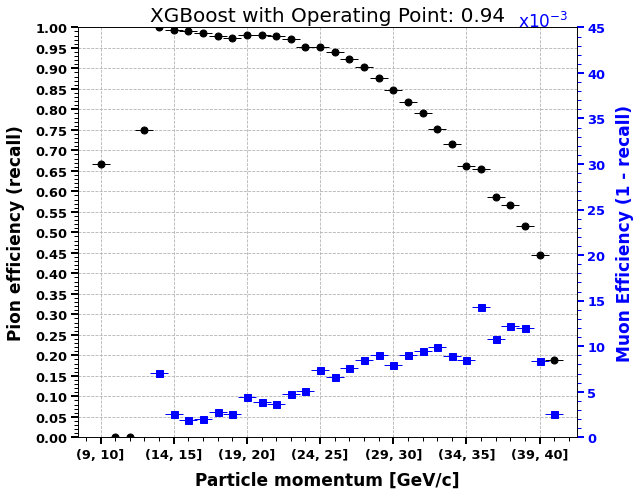

Operating point: 0.95
---------------------


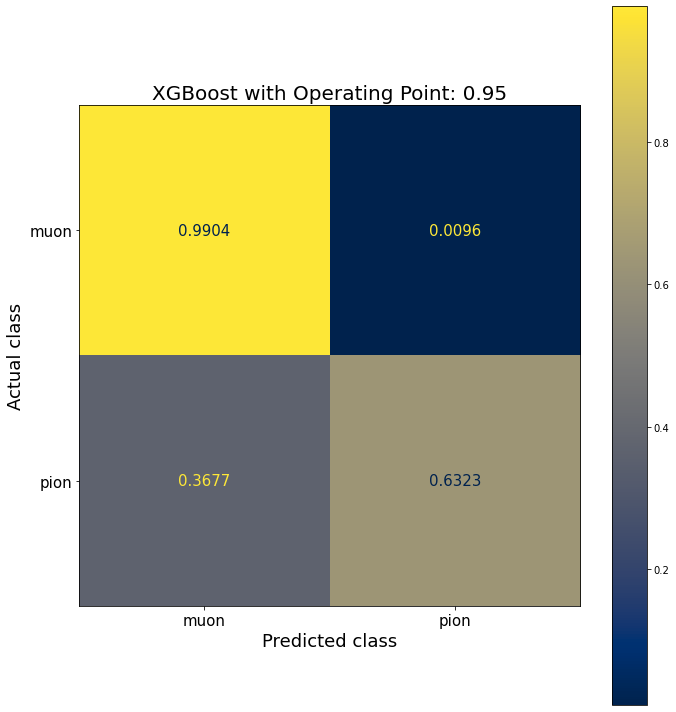

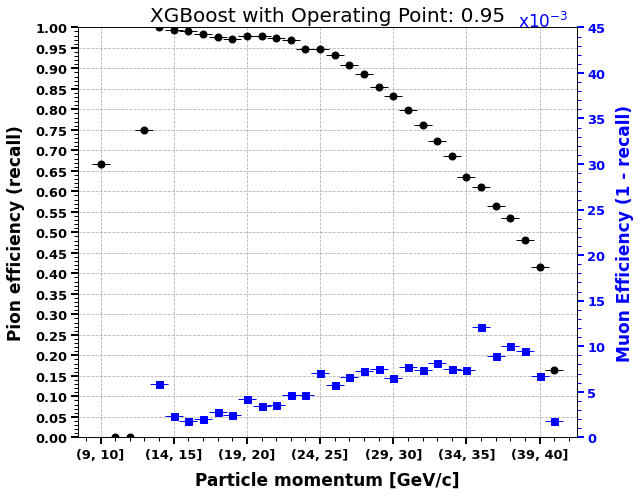

Operating point: 0.96
---------------------


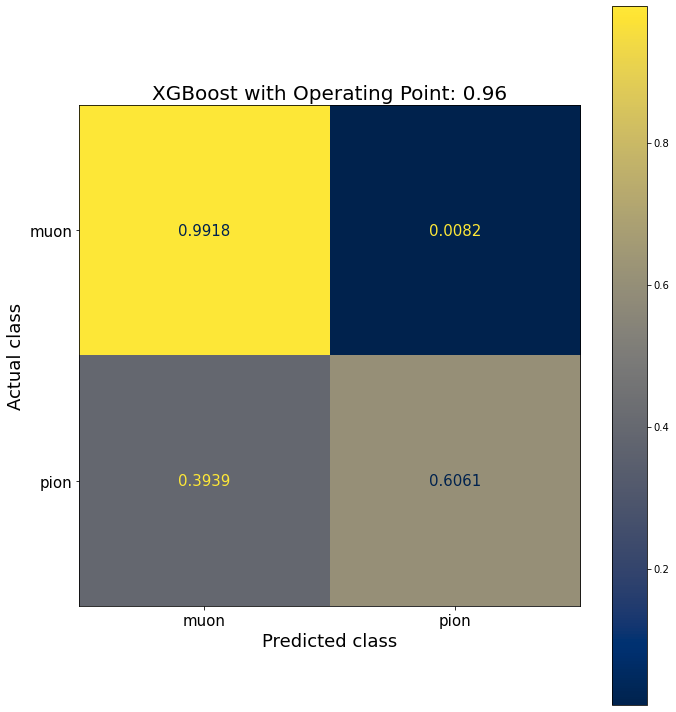

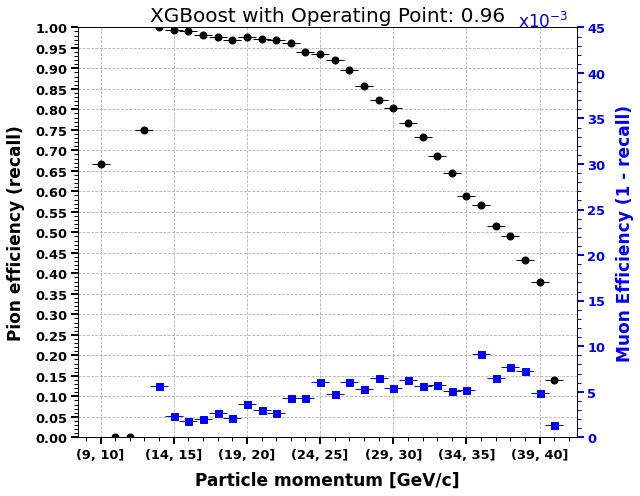

Operating point: 0.97
---------------------


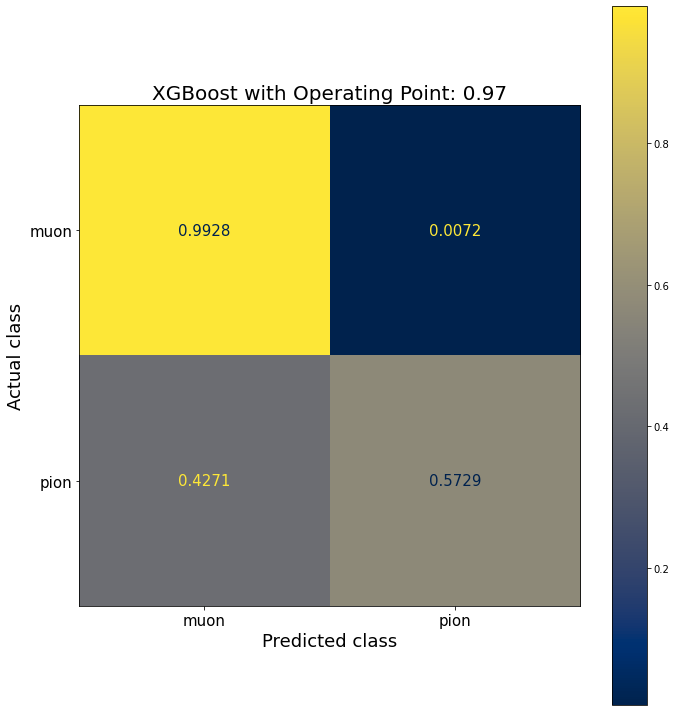

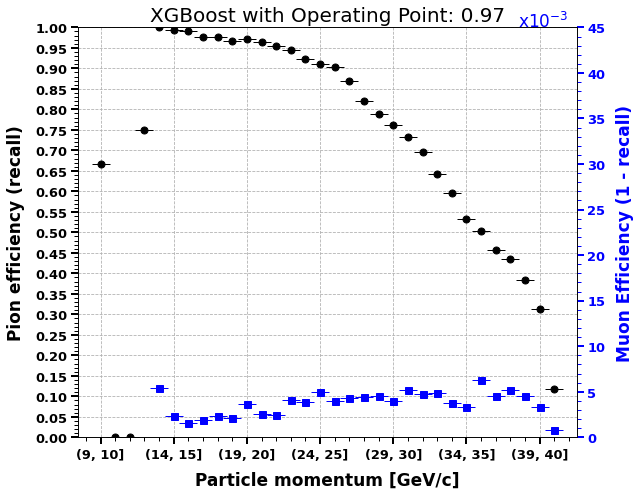

Operating point: 0.98
---------------------


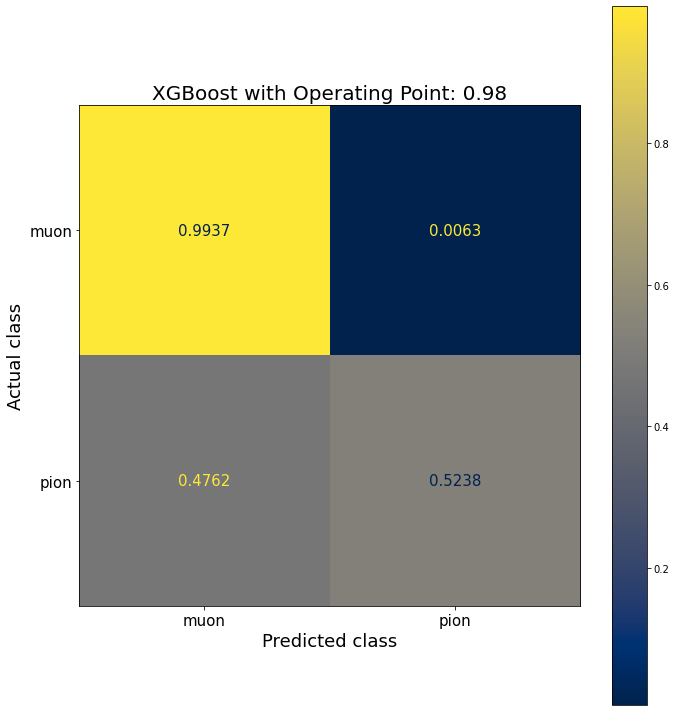

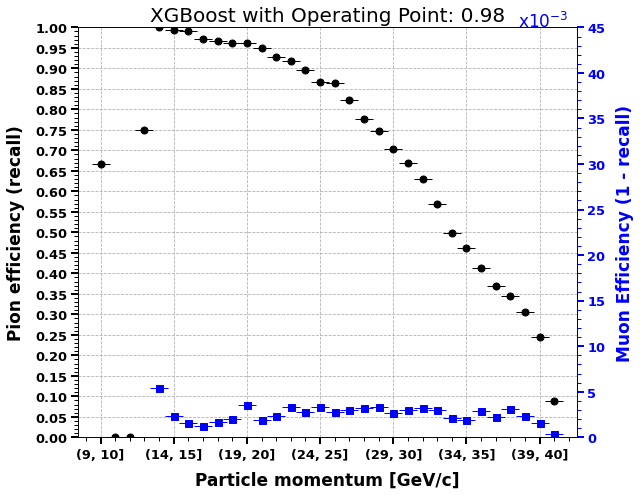

Operating point: 0.99
---------------------


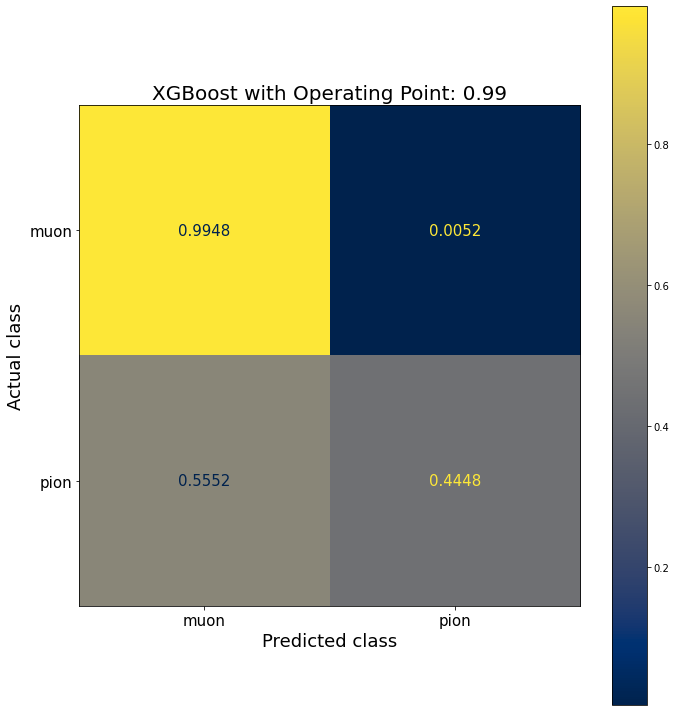

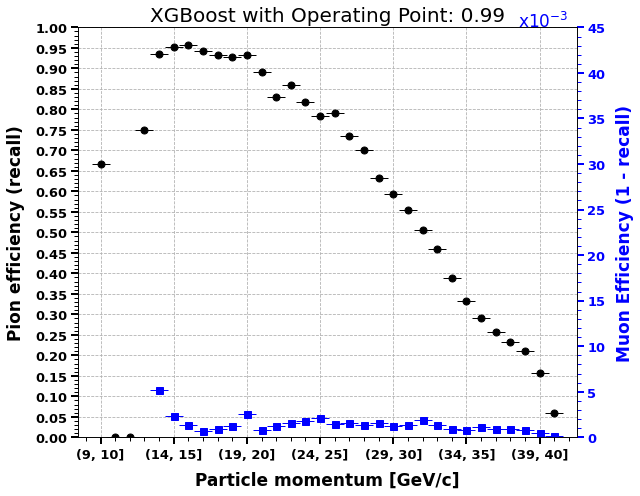

In [41]:
file_path = '/fast_scratch_1/capstone_2022/models/xgboost/saved_models/xgb_unbalanced.csv'

operating_point = [
    0.50,
    0.60,
    0.70,
    0.80,
    0.85,
    0.90,
    0.91,
    0.92,
    0.93,
    0.94,
    0.95,
    0.96,
    0.97,
    0.98,
    0.99,
]

for op in operating_point:
    print("\033[1;33m" + "Operating point: " + str(op) + "\033[0m")
    print("\033[1;33m" + "-" * len("Operating point: " + str(op)) + "\033[0m")
    
    title=f"XGBoost with Operating Point: {op}"
    
    df = pd.read_csv(file_path)
    df["predictions"] = np.where(df["probabilities"] > op, 1, 0)
    
    plot_cm(
        y_true=df["labels"],
        y_pred=df["predictions"],
        title=title
    )
    
    plot_efficiencies(
        path=file_path,
        title=title,
        cern_scale=True,
        pion_axlims=(0, 1),
        muon_axlims=(0, 45),
        pion_axticks=(0.05, 0.01),
        muon_axticks=(5, 1),
        op_point=op
)

## Observations on unbalanced test set performance

As observed, XGBoost Classifier trained on balanced data and tested on unbalanced data is not performing well. Therefore, further analysis on XGBoost is not being carried out